── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

ERROR: Error in library(themis): there is no package called ‘themis’


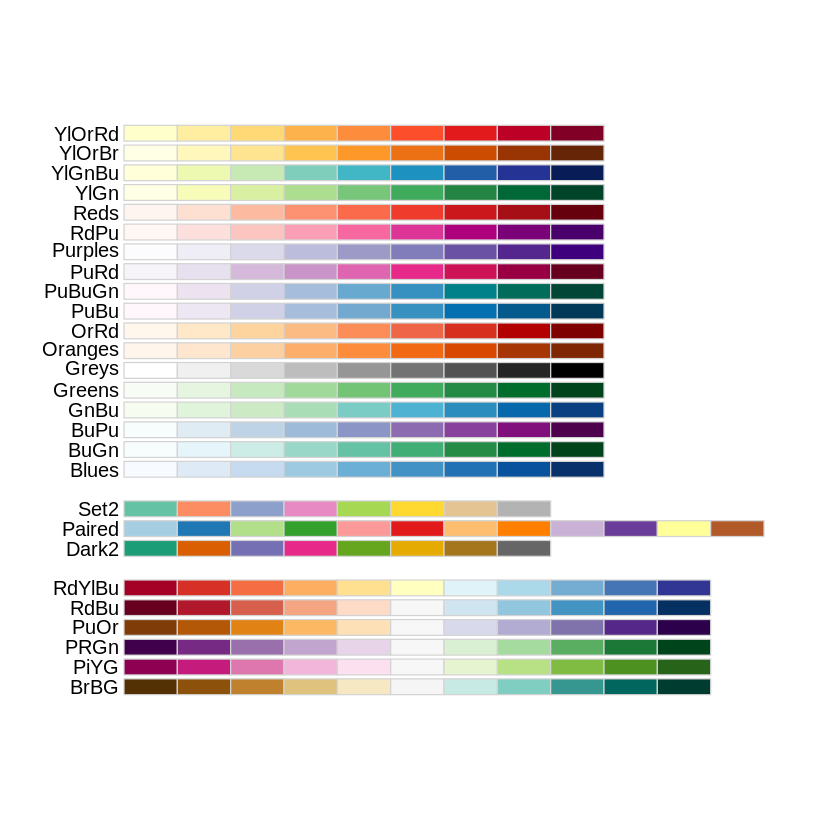

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(scales)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)
# Ensure the Palette used is colour blind friendly
display.brewer.all(colorblindFriendly = TRUE)
library(themis)

Parsed with column specification:
cols(
  Sector_score = col_double(),
  LOCATION_ID = col_character(),
  PARA_A = col_double(),
  SCORE_A = col_double(),
  PARA_B = col_double(),
  SCORE_B = col_double(),
  TOTAL = col_double(),
  numbers = col_double(),
  Marks = col_double(),
  Money_Value = col_double(),
  MONEY_Marks = col_double(),
  District = col_double(),
  Loss = col_double(),
  LOSS_SCORE = col_double(),
  History = col_double(),
  History_score = col_double(),
  Score = col_double(),
  Risk = col_double()
)

`summarise()` ungrouping output (override with `.groups` argument)



Risk,count,percentage
<fct>,<int>,<dbl>
Fraud,486,62.62887
No Fraud,290,37.37113


Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


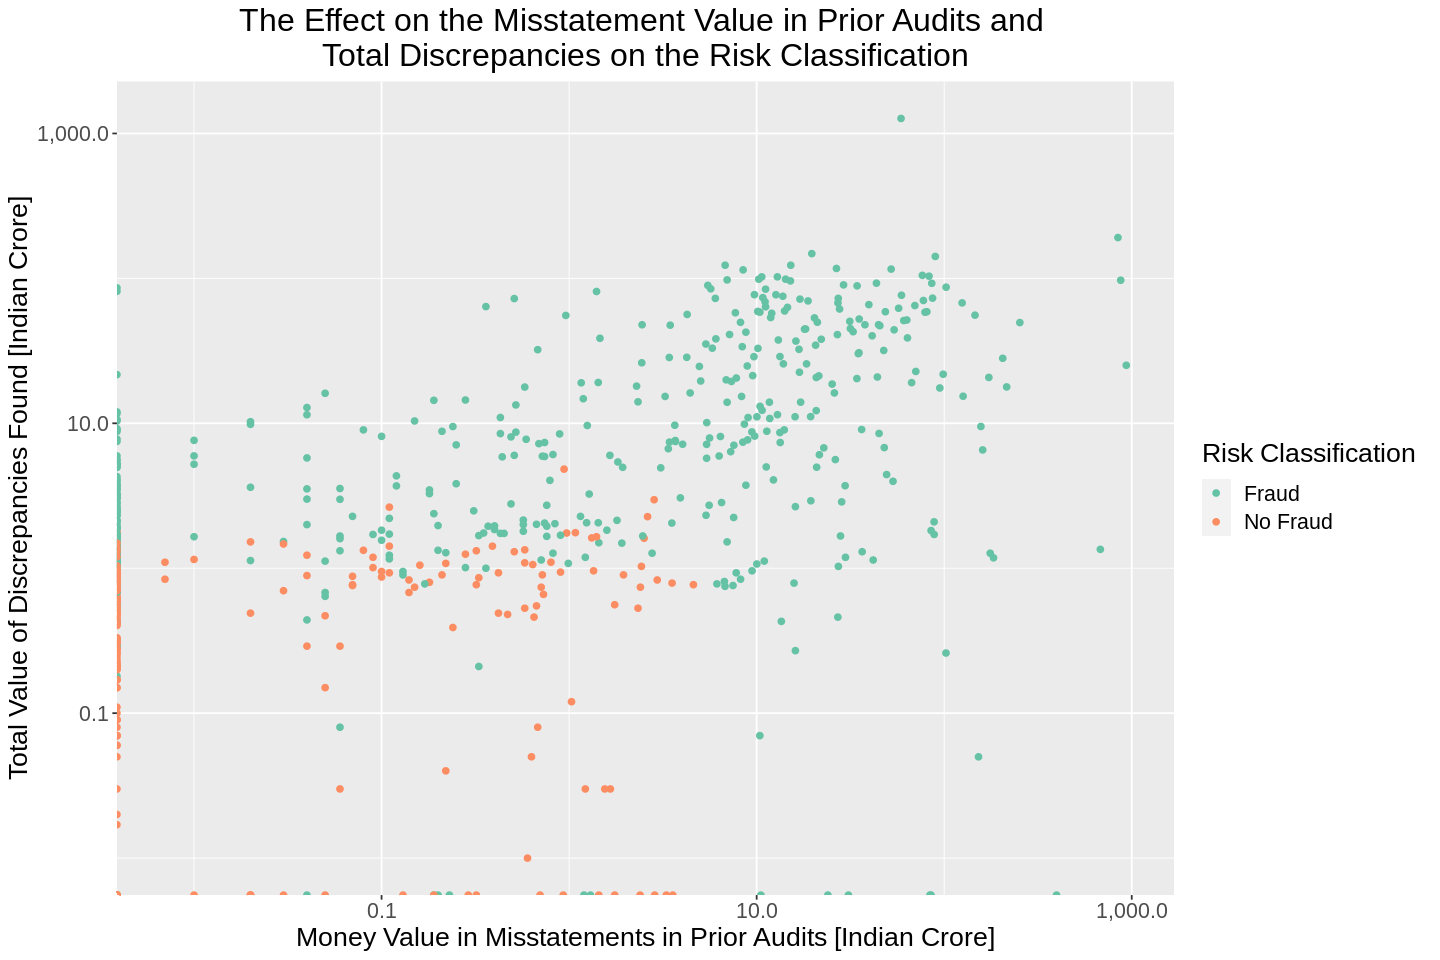

In [2]:
# Set seed to ensure randomness
set.seed(1001)

# Loading the Dataset
url = "https://raw.githubusercontent.com/fulleraltamiranoe/audit_data/main/trial.csv"
audit_trial_data <- read_csv(url) 

# Changing the Risk Classification to meaningful names
audit_trial_data$Risk <- ifelse(audit_trial_data$Risk == "1", "Fraud", "No Fraud")

# Treat Risk as factor
audit_trial_data <- audit_trial_data %>%
    mutate(Risk = as_factor(Risk))

# Group by Risk and Summarize to see how the Risk classification is ditributed
count <- audit_trial_data %>%
    group_by(Risk) %>%
    summarize(count = n(), percentage = n() / nrow(audit_trial_data) * 100)
count

# Visualizing original data utilizing a log scale
options(repr.plot.width = 12, repr.plot.height = 8) 
audit_original_plot <- audit_trial_data %>%
    ggplot(aes(x = Money_Value, y = TOTAL, colour = Risk)) +
    geom_point() +
    labs(x = "Money Value in Misstatements in Prior Audits [Indian Crore]", 
         y = "Total Value of Discrepancies Found [Indian Crore]", 
         colour = "Risk Classification") +
    ggtitle("The Effect on the Misstatement Value in Prior Audits and \nTotal Discrepancies on the Risk Classification") +
    theme(text = element_text(size = 16), plot.title = element_text(hjust = 0.5)) +
    scale_x_log10(labels = label_comma()) +
    scale_y_log10(labels = label_comma()) +
    scale_color_brewer(palette = "Set2")
audit_original_plot

In [3]:
# Cleaning the dataset and keeping predictors we will use
# From the above visualization, we can see thatmost firms
# are considered Fraud, we will balance the data set
audit <- audit_trial_data %>%
    select(Money_Value, TOTAL, Risk)
audit

# showcasing inbalance
count <- audit %>%
    group_by(Risk) %>%
    summarize(count = n(), percentage = n() / nrow(audit_trial_data) * 100)
count

# As seen above, Fraud data is over represented. Balancing original data
audit_recipe_balance <- recipe(Risk ~ TOTAL + Money_Value, data = audit) %>%
      step_upsample(Risk, over_ratio = 1, skip = FALSE) %>%
  prep()

upsampled_audit <- bake(audit_recipe_balance, audit)
upsampled_audit

upsampled_count <- upsampled_audit %>%
    group_by(Risk) %>%
    summarize(count = n(), percentage = n() / nrow(audit_trial_data) * 100)
upsampled_count

Money_Value,TOTAL,Risk
<dbl>,<dbl>,<fct>
3.38,6.68,Fraud
0.94,4.83,No Fraud
0.00,0.74,No Fraud
⋮,⋮,⋮
0.00,0.28,No Fraud
0.00,0.20,No Fraud
0.32,0.00,No Fraud


`summarise()` ungrouping output (override with `.groups` argument)



Risk,count,percentage
<fct>,<int>,<dbl>
Fraud,486,62.62887
No Fraud,290,37.37113


Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


TOTAL,Money_Value,Risk
<dbl>,<dbl>,<fct>
6.68,3.38,Fraud
10.80,11.75,Fraud
8.51,44.95,Fraud
⋮,⋮,⋮
0.03,1.22,No Fraud
1.88,0.00,No Fraud
0.62,0.00,No Fraud


`summarise()` ungrouping output (override with `.groups` argument)



Risk,count,percentage
<fct>,<int>,<dbl>
Fraud,486,62.62887
No Fraud,486,62.62887


In [6]:

# Splitting data into training and testing sets, 80% training data to ensure as much accuracy in 
# our model as possible.
audit_split <- initial_split(upsampled_audit, prop = 0.8, strata = Risk)  
audit_train <- training(audit_split)   
audit_test <- testing(audit_split)

# Count the number of instances of "Fraud" vs "No Fraud" firms
# in our training data (they are evenly distributed after upsampling)
count_training <- audit_train %>%
    group_by(Risk) %>%
    summarize(count = n(), percentage = n() / nrow(audit_train) * 100)
count_training



`summarise()` ungrouping output (override with `.groups` argument)



Risk,count,percentage
<fct>,<int>,<dbl>
Fraud,389,50
No Fraud,389,50


x Fold1: model 1/1 (predictions): Error: Problem with `mutate()` input `.row`.
[...

x Fold5: model 1/1 (predictions): Error: Problem with `mutate()` input `.row`.
[...



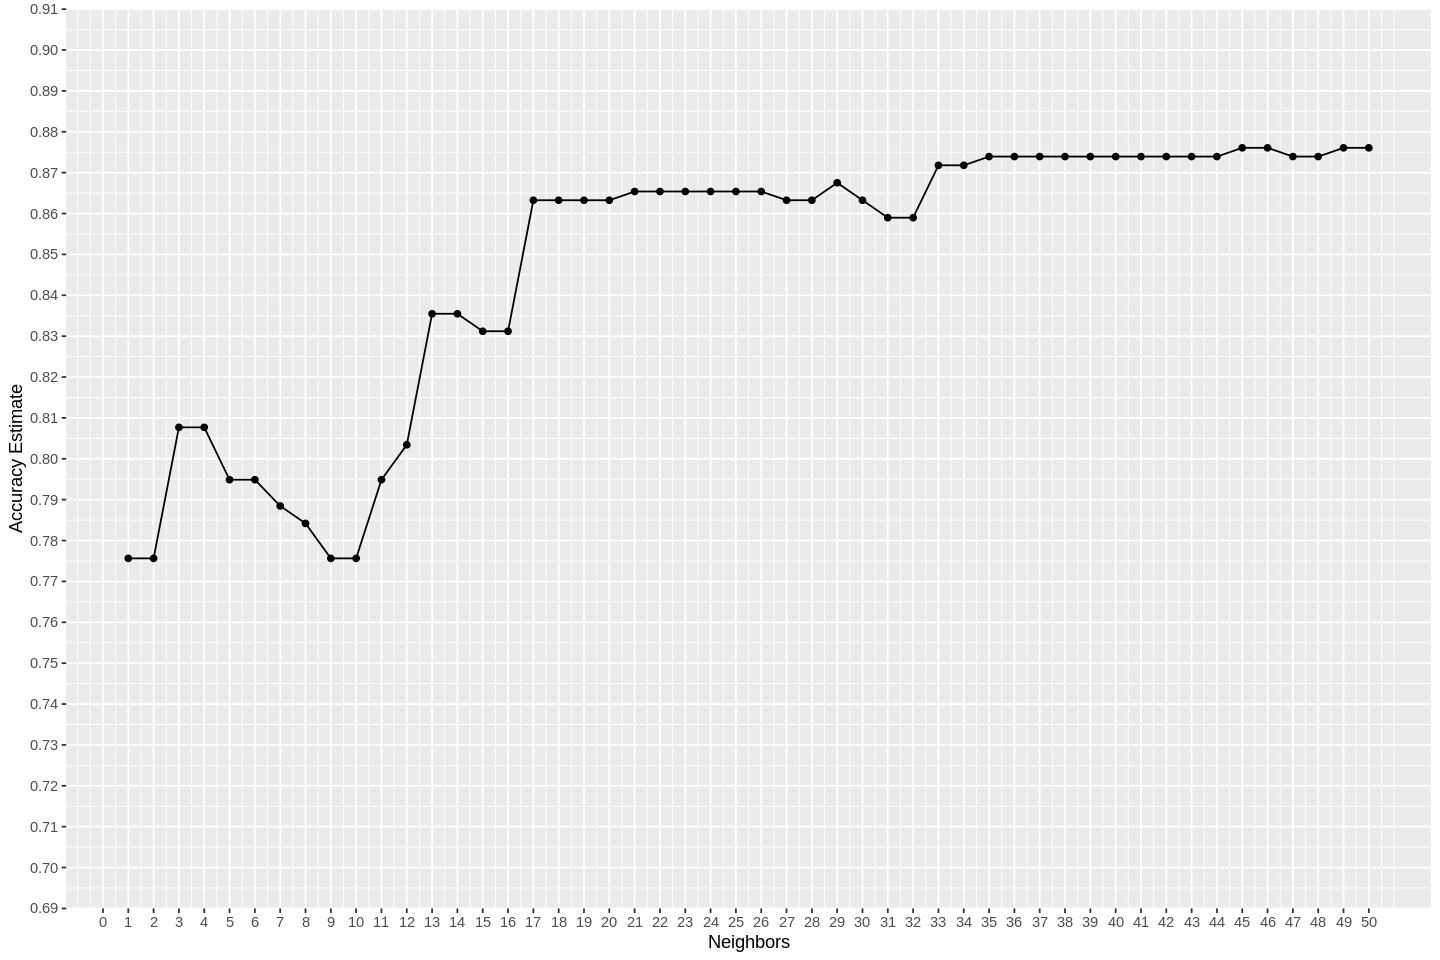

In [17]:
# Training, oversampling the 'No Fraud' because of the unbalance
audit_recipe <- recipe(Risk ~ TOTAL + Money_Value, data = audit_train) %>%
    step_scale(all_predictors())%>%
    step_center(all_predictors())

# tuning, how many K?
knn_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
    set_engine('kknn') %>%
    set_mode('classification')

audit_vfold <- vfold_cv(audit_train, v = 5, strata = Risk)

# Multiple maximum values of K were tested, after 50, the running the code takes too long and there's no significant increase in
# accuracy
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_results <- workflow() %>%
    add_recipe(audit_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = audit_vfold, grid = k_vals) %>%
    collect_metrics()

accuracies <- knn_results %>% 
    filter(.metric == 'accuracy')

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
    scale_x_continuous(limits = c(1, 50), breaks = seq(0, 50, by = 1)) +  # adjusting the x-axis
    scale_y_continuous(limits = c(0.7, 0.9), breaks = seq(0, 1, by = 0.01)) # adjusting the y-axis

accuracy_versus_k 

In [18]:
## K = 45 seems to be the most accurate
audit_knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 45) %>%
    set_engine('kknn') %>%
    set_mode('classification')

audit_fit <- workflow() %>%
    add_recipe(audit_recipe) %>%
    add_model(audit_knn_spec) %>%
    fit(data = audit_train)

audit_test_predictions <- predict(audit_fit, audit_test) %>%
    bind_cols(audit_test)

predictions_accuracy <- audit_test_predictions %>%
    metrics(truth = Risk, estimate = .pred_class)             

predictions_accuracy

audit_mat <- audit_test_predictions %>% 
    conf_mat(truth = Risk, estimate = .pred_class)   

audit_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8969072
kap,binary,0.7938144


          Truth
Prediction Fraud No Fraud
  Fraud       84        7
  No Fraud    13       90